In [2]:
import os
import math
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa
from tensorflow.keras.layers import (Input, Conv2D, BatchNormalization, Dropout, Dense, MaxPooling2D, 
                                     ReLU, Flatten, Softmax, GlobalAveragePooling2D, Concatenate, Add)
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold
import matplotlib.pyplot as plt

# Reading Train Images

In [3]:
train_df = pd.read_csv('../input/petfinder-pawpularity-score/train.csv')
train_df['Id'] = train_df['Id'].apply(lambda x: x + '.jpg')
print(train_df.shape)
dirs_df = pd.DataFrame(columns=['dirs'])
dirs_df['dirs'] = train_df[['Id']]
train_labels = train_df['Pawpularity']

(9912, 14)


In [4]:
n_splits = 10
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=2021)
dirs_df['fold'] = -1
dirs_df['label'] = train_labels
train_df['fold'] = -1

for fold, (tr, val) in enumerate(skf.split(dirs_df, train_labels)):
    dirs_df.loc[val, 'fold'] = fold
    train_df.loc[val, 'fold'] = fold

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


In [5]:
train_dirs = dirs_df[~dirs_df['fold'].isin([5, 6, 9])].drop(['fold', 'label'], axis=1)
train_labs = dirs_df[~dirs_df['fold'].isin([5, 6, 9])].drop(['fold', 'dirs'], axis=1)
X_train = train_df[~train_df['fold'].isin([5, 6, 9])].drop(['fold', 'Pawpularity', 'Id'], axis=1)
y_train = train_df[~train_df['fold'].isin([5, 6, 9])]['Pawpularity']


valid_dirs = dirs_df[dirs_df['fold'].isin([5, 6])].drop(['fold', 'label'], axis=1)
valid_labs = dirs_df[dirs_df['fold'].isin([5, 6])].drop(['fold', 'dirs'], axis=1)
X_valid = train_df[~train_df['fold'].isin([5, 6, 9])].drop(['fold', 'Pawpularity', 'Id'], axis=1)
y_valid = train_df[~train_df['fold'].isin([5, 6, 9])]['Pawpularity']


test_dirs = dirs_df[dirs_df['fold'] == 9].drop(['fold', 'label'], axis=1)
test_labs = dirs_df[dirs_df['fold'] == 9].drop(['fold', 'dirs'], axis=1)
X_test = train_df[~train_df['fold'].isin([5, 6, 9])].drop(['fold', 'Pawpularity', 'Id'], axis=1)
y_test = train_df[~train_df['fold'].isin([5, 6, 9])]['Pawpularity']

In [6]:
X_train_tensor = tf.data.Dataset.from_tensor_slices(X_train)
y_train_tensor = tf.data.Dataset.from_tensor_slices(y_train)

X_valid_tensor = tf.data.Dataset.from_tensor_slices(X_valid)
y_valid_tensor = tf.data.Dataset.from_tensor_slices(y_valid)

X_test_tensor = tf.data.Dataset.from_tensor_slices(X_test)
y_test_tensor = tf.data.Dataset.from_tensor_slices(y_test)

2021-12-03 17:28:11.924108: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-03 17:28:12.057214: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-03 17:28:12.058039: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-03 17:28:12.060144: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [7]:
train_dir = '../input/petfinder-pawpularity-score/train/'
train_dirs = [train_dir+branch for branch in train_dirs.dirs.tolist()]
valid_dirs = [train_dir+branch for branch in valid_dirs.dirs.tolist()]
test_dirs = [train_dir+branch for branch in test_dirs.dirs.tolist()]

In [8]:
sample = pd.read_csv('../input/petfinder-pawpularity-score/sample_submission.csv')

# Creating Tesorflow Dataset

In [9]:
train_ds = tf.data.Dataset.list_files(train_dirs, shuffle=False)
valid_ds = tf.data.Dataset.list_files(valid_dirs, shuffle=False)
test_ds = tf.data.Dataset.list_files(test_dirs, shuffle=False)

In [10]:
train_image_counts = len(train_ds)
print("Number of images =", train_image_counts)

valid_image_counts = len(valid_ds)
print("Number of images =", valid_image_counts)

test_image_counts = len(test_ds)
print("Number of images =", test_image_counts)

Number of images = 6939
Number of images = 1982
Number of images = 991


In [11]:
for path in train_ds.take(5):
    print(path.numpy())

b'../input/petfinder-pawpularity-score/train/0007de18844b0dbbb5e1f607da0606e0.jpg'
b'../input/petfinder-pawpularity-score/train/0009c66b9439883ba2750fb825e1d7db.jpg'
b'../input/petfinder-pawpularity-score/train/0013fd999caf9a3efe1352ca1b0d937e.jpg'
b'../input/petfinder-pawpularity-score/train/001dc955e10590d3ca4673f034feeef2.jpg'
b'../input/petfinder-pawpularity-score/train/001dd4f6fafb890610b1635f967ea081.jpg'


# Preprocessing 

In [12]:
BATCH_SIZE = 32
EPOCHS = 100
VERBOSE = 1

In [13]:
def process_image(file_path):
    # to read the file in tensorflow we need this function
    img = tf.io.read_file(file_path)
    # decode the image
    img = tf.image.decode_jpeg(img)
    # resize the image to have the same size for all images
    img = tf.image.resize(img, [224, 224])
    img = img/255.0
    return img

In [15]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds_images = train_ds.map(process_image)

In [16]:
def process_image(file_path):
    # to read the file in tensorflow we need this function
    img = tf.io.read_file(file_path)
    # decode the image
    img = tf.image.decode_jpeg(img)
    # resize the image to have the same size for all images
    img = tf.image.resize(img, [224, 224])
    img = img/255.0
    return img

In [17]:
valid_ds_images = valid_ds.map(process_image)

In [18]:
def process_image(file_path):
    # to read the file in tensorflow we need this function
    img = tf.io.read_file(file_path)
    # decode the image
    img = tf.image.decode_jpeg(img)
    # resize the image to have the same size for all images
    img = tf.image.resize(img, [224, 224])
    img = img/255.0
    return img

In [19]:
test_ds_images = test_ds.map(process_image)

In [20]:
train_tensor = tf.data.Dataset.zip(({'img': train_ds_images, 'table': X_train_tensor}, 
                                    y_train_tensor)).shuffle(1000).batch(BATCH_SIZE).prefetch(AUTOTUNE)

valid_tensor = tf.data.Dataset.zip(({'img': valid_ds_images, 'table': X_valid_tensor}, 
                                    y_valid_tensor)).shuffle(1000).batch(BATCH_SIZE).prefetch(AUTOTUNE)

test_tensor = tf.data.Dataset.zip(({'img': test_ds_images, 'table': X_test_tensor}, 
                                    y_test_tensor)).shuffle(1000).batch(BATCH_SIZE).prefetch(AUTOTUNE)

In [21]:
for epoch in range(5):
    for x, y in train_tensor:
        img = x['img']
        table = x['table']
        print(img.shape)
        print(table.shape)
        print(y.shape)
        break
    break

2021-12-03 17:32:57.273370: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


(32, 224, 224, 3)
(32, 12)
(32,)


In [22]:
for epoch in range(1):
    for x, y in valid_tensor:
        img = x['img']
        table = x['table']
        print(img.shape)
        print(table.shape)
        print(y.shape)
        break
    break

(32, 224, 224, 3)
(32, 12)
(32,)


In [23]:
for epoch in range(1):
    for x, y in test_tensor:
        img = x['img']
        table = x['table']
        print(img.shape)
        print(table.shape)
        print(y.shape)
        break
    break

(32, 224, 224, 3)
(32, 12)
(32,)


# Reading test images

In [ ]:
def test_process_image(file_path):
    # to read the file in tensorflow we need this function
    img = tf.io.read_file(file_path)
    # decode the image
    img = tf.image.decode_jpeg(img)
    # resize the image to have the same size for all images
    img = tf.image.resize(img, [224, 224])
    img = img/255.0
    return img

In [ ]:
test_images_ds = tf.data.Dataset.list_files('../input/petfinder-pawpularity-score/test/*', shuffle=False)
test_images_ds = test_images_ds.map(test_process_image).cache().batch(BATCH_SIZE).prefetch(AUTOTUNE)

# Swin Transformer

In [24]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
    BATCH_SIZE = tpu_strategy.num_replicas_in_sync * 64
    print("Running on TPU:", tpu.master())
    print(f"Batch Size: {BATCH_SIZE}")
    
except ValueError:
    strategy = tf.distribute.get_strategy()
    BATCH_SIZE = 512
    print(f"Running on {strategy.num_replicas_in_sync} replicas")
    print(f"Batch Size: {BATCH_SIZE}")

Running on 1 replicas
Batch Size: 512


In [25]:
input_shape = (224, 224, 3)
patch_size = (4, 4)  # 2-by-2 sized patches
dropout_rate = 0.03  # Dropout rate
num_heads = 8  # Attention heads
embed_dim = 64  # Embedding dimension
num_mlp = 256  # MLP layer size
qkv_bias = True  # Convert embedded patches to query, key, and values with a learnable additive value
window_size = 2  # Size of attention window
shift_size = 1  # Size of shifting window
image_dimension = 224  # Initial image size

num_patch_x = input_shape[0] // patch_size[0]
num_patch_y = input_shape[1] // patch_size[1]

learning_rate = 3e-4
batch_size = 32
num_epochs = 40
validation_split = 0.1
weight_decay = 1e-5
label_smoothing = 0.1

In [26]:
def window_partition(x, window_size):
    _, height, width, channels = x.shape
    patch_num_y = height // window_size
    patch_num_x = width // window_size
    x = tf.reshape(
        x, shape=(-1, patch_num_y, window_size, patch_num_x, window_size, channels)
    )
    x = tf.transpose(x, (0, 1, 3, 2, 4, 5))
    windows = tf.reshape(x, shape=(-1, window_size, window_size, channels))
    return windows


def window_reverse(windows, window_size, height, width, channels):
    patch_num_y = height // window_size
    patch_num_x = width // window_size
    x = tf.reshape(
        windows,
        shape=(-1, patch_num_y, patch_num_x, window_size, window_size, channels),
    )
    x = tf.transpose(x, perm=(0, 1, 3, 2, 4, 5))
    x = tf.reshape(x, shape=(-1, height, width, channels))
    return x


class DropPath(layers.Layer):
    def __init__(self, drop_prob=None, **kwargs):
        super(DropPath, self).__init__(**kwargs)
        self.drop_prob = drop_prob

    def call(self, x):
        input_shape = tf.shape(x)
        batch_size = input_shape[0]
        rank = x.shape.rank
        shape = (batch_size,) + (1,) * (rank - 1)
        random_tensor = (1 - self.drop_prob) + tf.random.uniform(shape, dtype=x.dtype)
        path_mask = tf.floor(random_tensor)
        output = tf.math.divide(x, 1 - self.drop_prob) * path_mask
        return output

In [27]:
class WindowAttention(layers.Layer):
    def __init__(
        self, dim, window_size, num_heads, qkv_bias=True, dropout_rate=0.0, **kwargs
    ):
        super(WindowAttention, self).__init__(**kwargs)
        self.dim = dim
        self.window_size = window_size
        self.num_heads = num_heads
        self.scale = (dim // num_heads) ** -0.5
        self.qkv = layers.Dense(dim * 3, use_bias=qkv_bias)
        self.dropout = layers.Dropout(dropout_rate)
        self.proj = layers.Dense(dim)

    def build(self, input_shape):
        num_window_elements = (2 * self.window_size[0] - 1) * (
            2 * self.window_size[1] - 1
        )
        self.relative_position_bias_table = self.add_weight(
            shape=(num_window_elements, self.num_heads),
            initializer=tf.initializers.Zeros(),
            trainable=True,
        )
        coords_h = np.arange(self.window_size[0])
        coords_w = np.arange(self.window_size[1])
        coords_matrix = np.meshgrid(coords_h, coords_w, indexing="ij")
        coords = np.stack(coords_matrix)
        coords_flatten = coords.reshape(2, -1)
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]
        relative_coords = relative_coords.transpose([1, 2, 0])
        relative_coords[:, :, 0] += self.window_size[0] - 1
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)

        self.relative_position_index = tf.Variable(
            initial_value=tf.convert_to_tensor(relative_position_index), trainable=False
        )

    def call(self, x, mask=None):
        _, size, channels = x.shape
        head_dim = channels // self.num_heads
        x_qkv = self.qkv(x)
        x_qkv = tf.reshape(x_qkv, shape=(-1, size, 3, self.num_heads, head_dim))
        x_qkv = tf.transpose(x_qkv, perm=(2, 0, 3, 1, 4))
        q, k, v = x_qkv[0], x_qkv[1], x_qkv[2]
        q = q * self.scale
        k = tf.transpose(k, perm=(0, 1, 3, 2))
        attn = q @ k

        num_window_elements = self.window_size[0] * self.window_size[1]
        relative_position_index_flat = tf.reshape(
            self.relative_position_index, shape=(-1,)
        )
        relative_position_bias = tf.gather(
            self.relative_position_bias_table, relative_position_index_flat
        )
        relative_position_bias = tf.reshape(
            relative_position_bias, shape=(num_window_elements, num_window_elements, -1)
        )
        relative_position_bias = tf.transpose(relative_position_bias, perm=(2, 0, 1))
        attn = attn + tf.expand_dims(relative_position_bias, axis=0)

        if mask is not None:
            nW = mask.get_shape()[0]
            mask_float = tf.cast(
                tf.expand_dims(tf.expand_dims(mask, axis=1), axis=0), tf.float32
            )
            attn = (
                tf.reshape(attn, shape=(-1, nW, self.num_heads, size, size))
                + mask_float
            )
            attn = tf.reshape(attn, shape=(-1, self.num_heads, size, size))
            attn = keras.activations.softmax(attn, axis=-1)
        else:
            attn = keras.activations.softmax(attn, axis=-1)
        attn = self.dropout(attn)

        x_qkv = attn @ v
        x_qkv = tf.transpose(x_qkv, perm=(0, 2, 1, 3))
        x_qkv = tf.reshape(x_qkv, shape=(-1, size, channels))
        x_qkv = self.proj(x_qkv)
        x_qkv = self.dropout(x_qkv)
        return x_qkv

In [28]:
class SwinTransformer(layers.Layer):
    def __init__(
        self,
        dim,
        num_patch,
        num_heads,
        window_size=7,
        shift_size=0,
        num_mlp=1024,
        qkv_bias=True,
        dropout_rate=0.0,
        **kwargs,
    ):
        super(SwinTransformer, self).__init__(**kwargs)

        self.dim = dim  # number of input dimensions
        self.num_patch = num_patch  # number of embedded patches
        self.num_heads = num_heads  # number of attention heads
        self.window_size = window_size  # size of window
        self.shift_size = shift_size  # size of window shift
        self.num_mlp = num_mlp  # number of MLP nodes

        self.norm1 = layers.LayerNormalization(epsilon=1e-5)
        self.attn = WindowAttention(
            dim,
            window_size=(self.window_size, self.window_size),
            num_heads=num_heads,
            qkv_bias=qkv_bias,
            dropout_rate=dropout_rate,
        )
        self.drop_path = DropPath(dropout_rate)
        self.norm2 = layers.LayerNormalization(epsilon=1e-5)

        self.mlp = keras.Sequential(
            [
                layers.Dense(num_mlp),
                layers.Activation(keras.activations.gelu),
                layers.Dropout(dropout_rate),
                layers.Dense(dim),
                layers.Dropout(dropout_rate),
            ]
        )

        if min(self.num_patch) < self.window_size:
            self.shift_size = 0
            self.window_size = min(self.num_patch)

    def build(self, input_shape):
        if self.shift_size == 0:
            self.attn_mask = None
        else:
            height, width = self.num_patch
            h_slices = (
                slice(0, -self.window_size),
                slice(-self.window_size, -self.shift_size),
                slice(-self.shift_size, None),
            )
            w_slices = (
                slice(0, -self.window_size),
                slice(-self.window_size, -self.shift_size),
                slice(-self.shift_size, None),
            )
            mask_array = np.zeros((1, height, width, 1))
            count = 0
            for h in h_slices:
                for w in w_slices:
                    mask_array[:, h, w, :] = count
                    count += 1
            mask_array = tf.convert_to_tensor(mask_array)

            # mask array to windows
            mask_windows = window_partition(mask_array, self.window_size)
            mask_windows = tf.reshape(
                mask_windows, shape=[-1, self.window_size * self.window_size]
            )
            attn_mask = tf.expand_dims(mask_windows, axis=1) - tf.expand_dims(
                mask_windows, axis=2
            )
            attn_mask = tf.where(attn_mask != 0, -100.0, attn_mask)
            attn_mask = tf.where(attn_mask == 0, 0.0, attn_mask)
            self.attn_mask = tf.Variable(initial_value=attn_mask, trainable=False)

    def call(self, x):
        height, width = self.num_patch
        _, num_patches_before, channels = x.shape
        x_skip = x
        x = self.norm1(x)
        x = tf.reshape(x, shape=(-1, height, width, channels))
        if self.shift_size > 0:
            shifted_x = tf.roll(
                x, shift=[-self.shift_size, -self.shift_size], axis=[1, 2]
            )
        else:
            shifted_x = x

        x_windows = window_partition(shifted_x, self.window_size)
        x_windows = tf.reshape(
            x_windows, shape=(-1, self.window_size * self.window_size, channels)
        )
        attn_windows = self.attn(x_windows, mask=self.attn_mask)

        attn_windows = tf.reshape(
            attn_windows, shape=(-1, self.window_size, self.window_size, channels)
        )
        shifted_x = window_reverse(
            attn_windows, self.window_size, height, width, channels
        )
        if self.shift_size > 0:
            x = tf.roll(
                shifted_x, shift=[self.shift_size, self.shift_size], axis=[1, 2]
            )
        else:
            x = shifted_x

        x = tf.reshape(x, shape=(-1, height * width, channels))
        x = self.drop_path(x)
        x = x_skip + x
        x_skip = x
        x = self.norm2(x)
        x = self.mlp(x)
        x = self.drop_path(x)
        x = x_skip + x
        return x

In [29]:
class PatchExtract(layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super(PatchExtract, self).__init__(**kwargs)
        self.patch_size_x = patch_size[0]
        self.patch_size_y = patch_size[0]

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=(1, self.patch_size_x, self.patch_size_y, 1),
            strides=(1, self.patch_size_x, self.patch_size_y, 1),
            rates=(1, 1, 1, 1),
            padding="VALID",
        )
        patch_dim = patches.shape[-1]
        patch_num = patches.shape[1]
        return tf.reshape(patches, (batch_size, patch_num * patch_num, patch_dim))


class PatchEmbedding(layers.Layer):
    def __init__(self, num_patch, embed_dim, **kwargs):
        super(PatchEmbedding, self).__init__(**kwargs)
        self.num_patch = num_patch
        self.proj = layers.Dense(embed_dim)
        self.pos_embed = layers.Embedding(input_dim=num_patch, output_dim=embed_dim)

    def call(self, patch):
        pos = tf.range(start=0, limit=self.num_patch, delta=1)
        return self.proj(patch) + self.pos_embed(pos)


class PatchMerging(tf.keras.layers.Layer):
    def __init__(self, num_patch, embed_dim):
        super(PatchMerging, self).__init__()
        self.num_patch = num_patch
        self.embed_dim = embed_dim
        self.linear_trans = layers.Dense(2 * embed_dim, use_bias=False)

    def call(self, x):
        height, width = self.num_patch
        _, _, C = x.get_shape().as_list()
        x = tf.reshape(x, shape=(-1, height, width, C))
        x0 = x[:, 0::2, 0::2, :]
        x1 = x[:, 1::2, 0::2, :]
        x2 = x[:, 0::2, 1::2, :]
        x3 = x[:, 1::2, 1::2, :]
        x = tf.concat((x0, x1, x2, x3), axis=-1)
        x = tf.reshape(x, shape=(-1, (height // 2) * (width // 2), 4 * C))
        return self.linear_trans(x)

In [30]:
def swin_transformer_with_mlp_model():
    
    # Images Swin Transformer
    input_1 = layers.Input(input_shape, name='img')
    x = PatchExtract(patch_size)(input_1)
    x = PatchEmbedding(num_patch_x * num_patch_y, embed_dim)(x)
    x = SwinTransformer(
        dim=embed_dim,
        num_patch=(num_patch_x, num_patch_y),
        num_heads=num_heads,
        window_size=window_size,
        shift_size=0,
        num_mlp=num_mlp,
        qkv_bias=qkv_bias,
        dropout_rate=dropout_rate,
    )(x)
    x = SwinTransformer(
        dim=embed_dim,
        num_patch=(num_patch_x, num_patch_y),
        num_heads=num_heads,
        window_size=window_size,
        shift_size=shift_size,
        num_mlp=num_mlp,
        qkv_bias=qkv_bias,
        dropout_rate=dropout_rate,
    )(x)
    x = PatchMerging((num_patch_x, num_patch_y), embed_dim=embed_dim)(x)
    x = layers.GlobalAveragePooling1D()(x)
    x_1 = tf.keras.layers.LeakyReLU()(x)
    
    # Metadata MLP
    input_2 = Input(shape=(12,), name='table')
    x = Dense(256)(input_2)
    x = tf.keras.layers.LeakyReLU()(x)
    x = Dense(128)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = Dense(128)(x)
    x_2 = tf.keras.layers.LeakyReLU()(x)

    concat = Concatenate()([x_1, x_2])

    x = Dense(64)(concat)
    x = tf.keras.layers.LeakyReLU()(x)
    output = layers.Dense(1, activation='relu')(x)
    
    model = Model(inputs=[input_1, input_2], outputs=output)
    return model

In [31]:
optimizer = tfa.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay)
loss_fn = tf.keras.losses.MeanSquaredError()
acc_metric = tf.keras.metrics.RootMeanSquaredError()
acc_metric_valid = tf.keras.metrics.RootMeanSquaredError()

In [32]:
model = swin_transformer_with_mlp_model()
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
patch_extract (PatchExtract)    (None, 3136, 48)     0           img[0][0]                        
__________________________________________________________________________________________________
table (InputLayer)              [(None, 12)]         0                                            
__________________________________________________________________________________________________
patch_embedding (PatchEmbedding (None, 3136, 64)     203840      patch_extract[0][0]              
______________________________________________________________________________________________

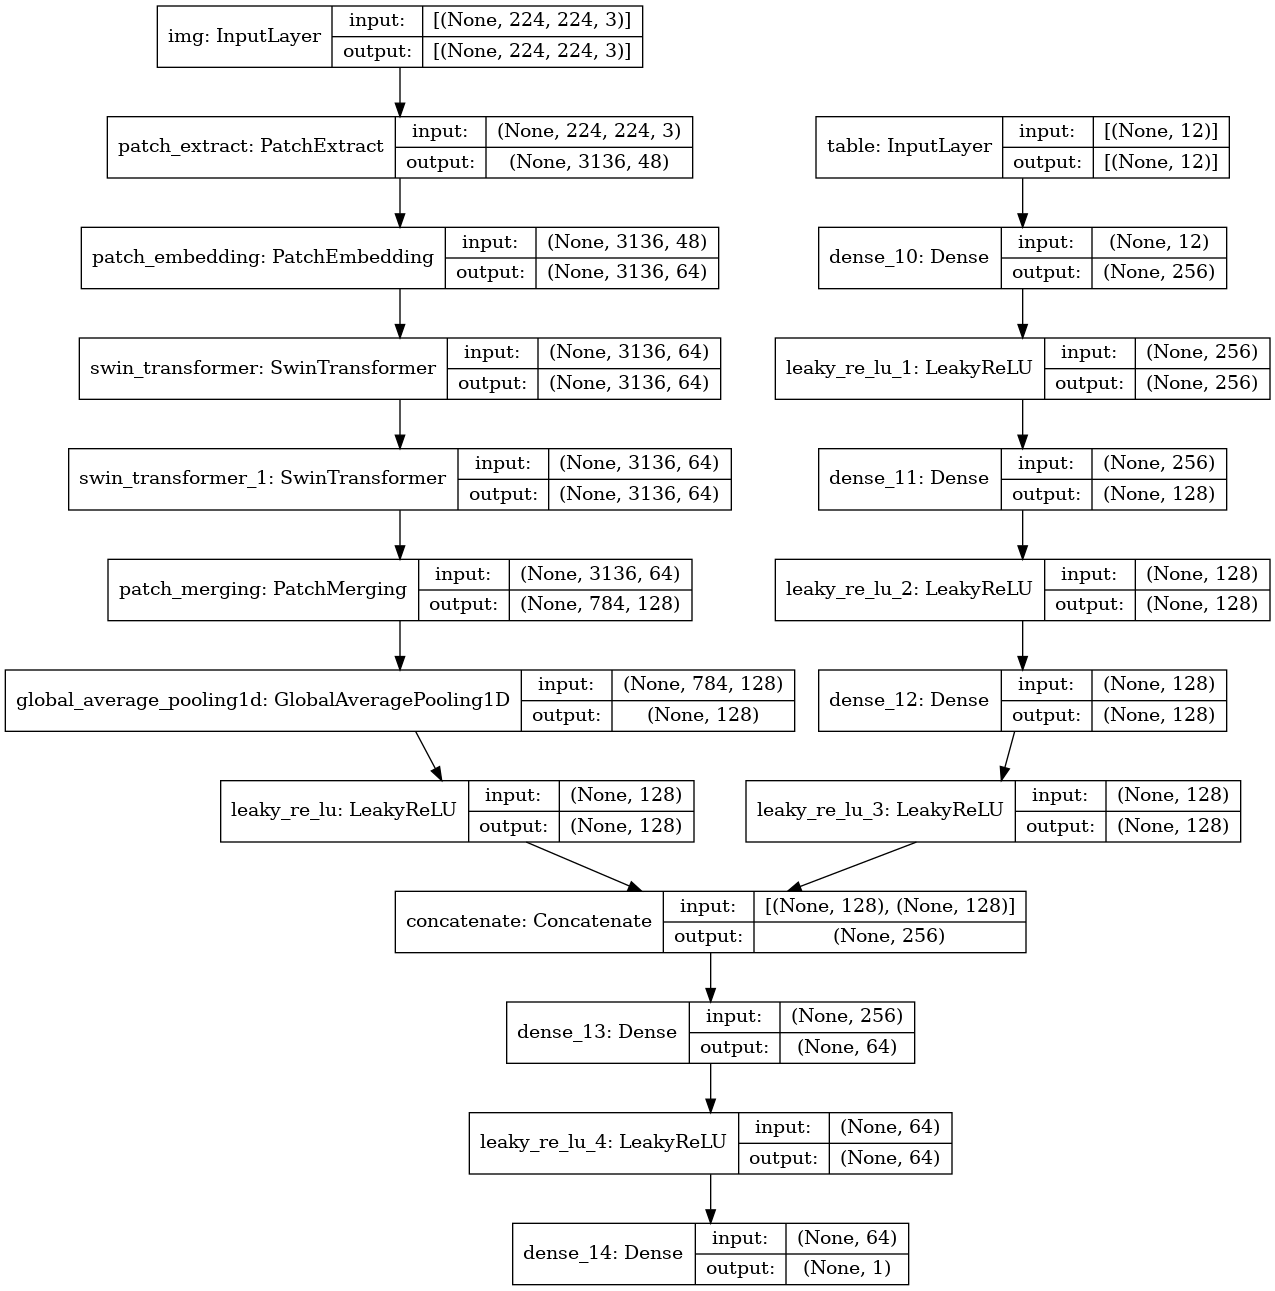

In [33]:
# plot the model
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [34]:
num_epochs = 10
for epoch in range(num_epochs):
    print(f"\n Start of Training Epoch {epoch+1}")
    for batch_idx, ((x_batch, y_batch), (x_batch_valid, y_batch_valid)) in enumerate(zip(train_tensor, valid_tensor)):
        img = x_batch['img']
        table = x_batch['table']
        
        img_valid = x_batch_valid['img']
        table_valid = x_batch_valid['table']
        
        # tape forward pass of training data
        with tf.GradientTape() as tape:
            y_pred = model((img, table), training=True)
            loss = loss_fn(y_batch, y_pred)
            
        # calculate grads of loss with respect to trainable parameters
        gradients = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(gradients, model.trainable_weights))
        acc_metric.update_state(y_batch, y_pred)
        
        # tape forward pass validation data
        with tf.GradientTape() as tape_valid:
            y_pred_valid = model((img_valid, table_valid), training=False)
            loss_valid = loss_fn(y_batch_valid, y_pred_valid)
            
        acc_metric_valid.update_state(y_batch_valid, y_pred_valid)
        
    train_acc = acc_metric.result()
    valid_acc = acc_metric_valid.result()
    print(f"Train RMSE of epoch {train_acc}")
    print(f"Valid RMSE of epoch {valid_acc}")
    # reset the accuracy metrics to start from 0 for the next epoch
    acc_metric.reset_states()
    acc_metric_valid.reset_states()


 Start of Training Epoch 1
Train RMSE of epoch 25.72970199584961
Valid RMSE of epoch 25.659976959228516

 Start of Training Epoch 2
Train RMSE of epoch 21.433549880981445
Valid RMSE of epoch 21.524456024169922

 Start of Training Epoch 3
Train RMSE of epoch 21.529705047607422
Valid RMSE of epoch 21.440584182739258

 Start of Training Epoch 4
Train RMSE of epoch 21.060060501098633
Valid RMSE of epoch 21.51833152770996

 Start of Training Epoch 5
Train RMSE of epoch 21.136600494384766
Valid RMSE of epoch 21.444313049316406

 Start of Training Epoch 6
Train RMSE of epoch 20.61107063293457
Valid RMSE of epoch 21.571014404296875

 Start of Training Epoch 7
Train RMSE of epoch 20.717336654663086
Valid RMSE of epoch 21.45154571533203

 Start of Training Epoch 8
Train RMSE of epoch 21.374244689941406
Valid RMSE of epoch 21.419166564941406

 Start of Training Epoch 9
Train RMSE of epoch 21.005456924438477
Valid RMSE of epoch 21.395065307617188

 Start of Training Epoch 10
Train RMSE of epoch 2